# Шумоподавляющий автокодировщик

Denoising autoencoder (DAE)

Задание: создать модель для подавления шумов в медицинских изображениях.

В этой работе мы повторим идею из статьи "Medical image denoising using convolutional denoising autoencoders".

In [513]:
# код для варианта

name = "Корчагин Илья Вадимович" # Впишите ваше ФИО

def calculate_variant(name):
    return sum(ord(char) for char in name) % 2 + 1

print(f"Ваш вариант - №{calculate_variant(name)}")

Ваш вариант - №1


## Варианты

1. OrganSMNISВT
1. ChestMNIST
1. PneumoniaMNIST

## Порядок выполнения

1. Загрузить датасет по варианту;
1. Провести предварительную обработку данных;
1. Используя фреймворк PyTorch создать модель;
1. Обучить модель;
1. Попробовать подобрать гиперпараметры;
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf)
1. [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
1. [Автокодировщик](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA)

## Статьи из разбора

1. [LLNet: A Deep Autoencoder approach to Natural Low-light Image Enhancement](https://arxiv.org/pdf/1511.03995.pdf)
1. [Deep Learning on Image Denoising: An Overview](https://arxiv.org/pdf/1912.13171.pdf)
1. [Boltzmann Machines and Denoising Autoencoders for Image Denoising](https://arxiv.org/pdf/1301.3468.pdf)
1. [Denoising Vanilla Autoencoder for RGB and GS Images with Gaussian Noise](https://app.dimensions.ai/details/publication/pub.1165117438)

## Импортирование модулей

In [514]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

В этой работе можете попробовать задействовать GPU для ускорения вычислений. [How To Use GPU with PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk)

In [515]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

Работаем на CPU


Изначально тензоры создаются на CPU, и с помощью метода `.to(device)` на тензорах и моделях вы можете переносить их с устройства на устройство. Если в результате вычислений создаются новые тензоры, то они уже создаются на устройствах, на которых производились эти вычисления.

## Загрузка данных

Ссылка на подборку датасетов - https://medmnist.com/. По этой ссылке вы найдете описание самих датасетов, а также инструкцию по установке библиотеки и созданию объекта DataClass и далее DataLoader.

[Официальный пример](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) как пользоваться датасетом и как загрузить его данные от самих разработчиков.

In [516]:
#
# Ваш код для DataSet и DataLoader
#
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'chestmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: C:\Users\User.DESKTOP-J18NSGP\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\User.DESKTOP-J18NSGP\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\User.DESKTOP-J18NSGP\.medmnist\chestmnist.npz


**Какие преобразования вы применили при создании DataSet и почему?**

Ваш ответ: перевели данные в тензор для обработки pytorch'ем и нормализовали этот тензор

## Создание модели

Автокодировщик (автоэнкодер) состоит из двух частей и вывод первой части является входом второй части. Строение модели вы можете посмотреть в статье в описании и воспроизвести ее. Создание слоев свертки вам знакомо с предыдущей работы, а для декодера вам потребуется двумерная транспонированная свертка (ConvTranspose2d).

In [517]:
hidden_size = 500
# кодировщик
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(1, 128, 3, padding=1),
      nn.ReLU(),
      #nn.MaxPool2d(2, 2),
      #nn.Conv2d(128, 32, 3),
      #nn.ReLU(),
      #nn.MaxPool2d(2, 2),
      nn.Conv2d(128, 8, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
        #
        # ваш код
        #
    )

  def forward(self, x):
    output = self.conv(x)
    return output  # здесь на выходе может быть произвольный тензор


#  декодер
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(8, 128, 2, stride=2),
      nn.ReLU(),
      #nn.MaxUnpool2d(2, 2),
      #nn.Conv2d(32, 128, 3),
      #nn.ReLU(),
      #nn.MaxPool2d(2, 2),
      nn.ConvTranspose2d(128, 1, 2, stride=2),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
        #
        # ваш код
        #
    )

  def forward(self, x):
    output = self.conv(x)
    # Помните, что здесь на входе должен приниматься тензор размерностью как у кодировщика на выходе
    #
    # ваш код
    #
    return output  # На выходе должен быть тензор размерностью как исходное изображение.

**В чем разница между сверткой и транспонированной сверткой?**

Ваш ответ: Транспонированная свертка, в отличие от обычной свертки, не уменьшает выходное изображение, а наоборот увеличивает его

Далее кодировщик и декодировщик мы объединяем в автокодировщик.

In [518]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    # self.encoder.to(device)

    self.decoder = decoder
    # self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Обучение

В качестве оптимизатора можете использовать SGD или Adam или в целом попробовать другие оптимизаторы, что предлагает pytorch.

В качестве функции потерь воспользуйтесь MSE (MSELoss) или другой функцией, которая подходит для сравнения изображений.

In [519]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name + '.png')

In [520]:
log_dict = {
    'training_loss_per_batch': [],
    'validation_loss_per_batch': [],
}
origin_images = []
noise_images = []

epochs = 5 #10
encoder = Encoder()
decoder = Decoder()
model = Autoencoder(encoder, decoder)

optimizer = torch.optim.SGD(model.parameters(), lr)
loss_fn = nn.MSELoss()
#dropout = nn.Dropout()
for epoch in range(epochs):
  i = 0
  print(f'Эпоха {epoch+1}/{epochs}')
  train_losses = []

  print('обучение...')
  model.train()
  for images in train_loader:
    # Шаги для обучения:
    # 1. загрузить изображения
    # 2. добавить гауссовский шум шум (torch.normal() и clip() / clamp())
    # 3. реконструировать изображение (прямой проход через энкодер и декодер)
    # 4. рассчитать `loss`
    # 5. выполнить `loss.backward ()` для вычисления градиентов функции потери относительно параметров модели
    # 6. выполнить шаг оптимизации `optimizer.step ()`
    # 7. занулить градиенты

    #
    # ваш код
    #
    i+=1
    image, y = images
    #image = image.view(image.size(0), -1)
    #noise = dropout(torch.ones(image.shape))
    img_noise = image + torch.normal(image)
    # clip to make the values fall between 0 and 1
    #print(img_noise)
    img_noise = torch.clip(img_noise, 0., 1.)
    #print(img_noise)
    # print(image)
    # noise = torch.normal(image)
    # print (noise)
    # img_noise = image.clamp(image)
    # print(img_noise)
    # img_noise = img_noise.clip(image)
    # print(img_noise)
    res = model(img_noise)
    loss = loss_fn(res, img_noise)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    log_dict['training_loss_per_batch'].append(loss.item())
    save_decoded_image(img_noise.cpu().data, name='noisy{}'.format(epoch))
    
    save_decoded_image(res.cpu().data, name='denoised{}'.format(epoch))
    if i % 100 == 0:
      origin_images.append(image)
      noise_images.append(img_noise)
      

  # Валидация
  print('валидация...')
  model.eval()
  for val_images in train_loader_at_eval:
    with torch.no_grad():
      #
      # ваш код
      #
      imag, y = val_images
      #imag = imag.view(imag.size(0), -1)
      img_noisy = imag + torch.normal(imag, 0.5)
      img_noisy = np.clip(img_noisy, 0., 1.)
      #img_noisy = img_noisy.to(device)
      test_res = model(img_noisy)
      val_loss = loss_fn(test_res, img_noisy)

      log_dict['validation_loss_per_batch'].append(val_loss.item())
print('Обучение завершено')

Эпоха 1/5
обучение...
валидация...
Эпоха 2/5
обучение...
валидация...
Эпоха 3/5
обучение...
валидация...
Эпоха 4/5
обучение...
валидация...
Эпоха 5/5
обучение...
валидация...
Обучение завершено


**Что делает clip() или clamp() и почему его требуется использовать после добавления шума?**

Ваш ответ: clip() обрезает значения вне интервала до краев интервала

## Контроль результатов и экспериментов

Вы всегда должны следить за тем как идет обучение и как меняются метрики в его процессе. В этой работе вы можете воспользоваться [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html) или создать переменную со списком и в него складывать значения с каждых n итераций и с помощью matplotlib строить графики.

Далее приведены части кода, которые позволят в Google Colab воспользоваться TensorBoard для PyTorch.

In [521]:


from torch.utils.tensorboard import SummaryWriter # Импорт модуля
#%load_ext tensorboard  # Загружает один раз расширение для ноутбука. Эту команду можно перенести в самое начало.

writer = SummaryWriter()  # создание экземпляра класса, который отвечает за ведение логов.

for n_iter in range(100): # в цикле обучения вы используете метод add_scalar или другие для добавления записи в логи.
    writer.add_scalar('Loss/train', np.random.random(), n_iter)  # пример вызова самого метода.
#%tensorboard --logdir runs # Запускает сам tensorboard в выводе текущей ячейки. Лучше перенести в самый конец.

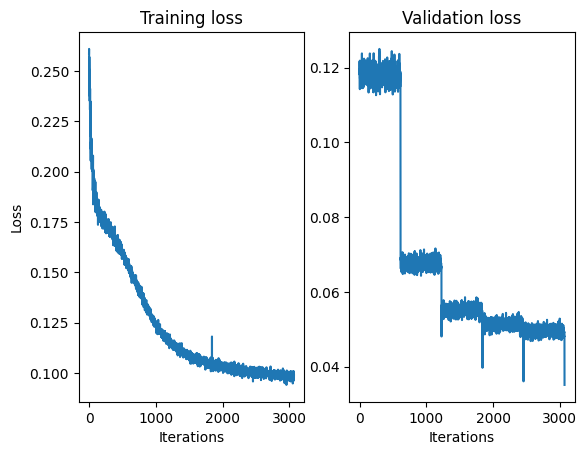

In [522]:
_, axis = plt.subplots(1, 2)
#plt.style.use('fivethirtyeight')
axis[0].set_title('Training loss')
axis[0].plot(log_dict['training_loss_per_batch'])
axis[0].set_xlabel('Iterations')
axis[0].set_ylabel('Loss')
axis[1].set_xlabel('Iterations')

axis[1].set_title('Validation loss')
axis[1].plot(log_dict['validation_loss_per_batch'])
plt.show()

**По графикам потерь и метрике сделайте вывод была ли модель обучена, недообучена или переобучена.**

Ваш ответ: Модель была недообучена

**Если модель недообучена или переобучена, то что могло послужить причинами этого?**

Ваш ответ: Количество итераций

## Результат работы модели

Выведите итоговую метрику для тестовых изображений. И отобразите несколько примеров работы модели: исходное изображение и с убранным шумом.

Пример для цветных изображений.

```python
test_images = test_images.to(device)
with torch.no_grad():
  reconstructed_imgs = network(test_images)
reconstructed_imgs = reconstructed_imgs.cpu()
test_images = test_images.cpu()
imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], dim=1).flatten(0,1)
grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)
plt.figure(dpi=170)
plt.title('Original/Reconstructed')
plt.imshow(grid)
log_dict['visualizations'].append(grid)
plt.axis('off')
plt.show()
```

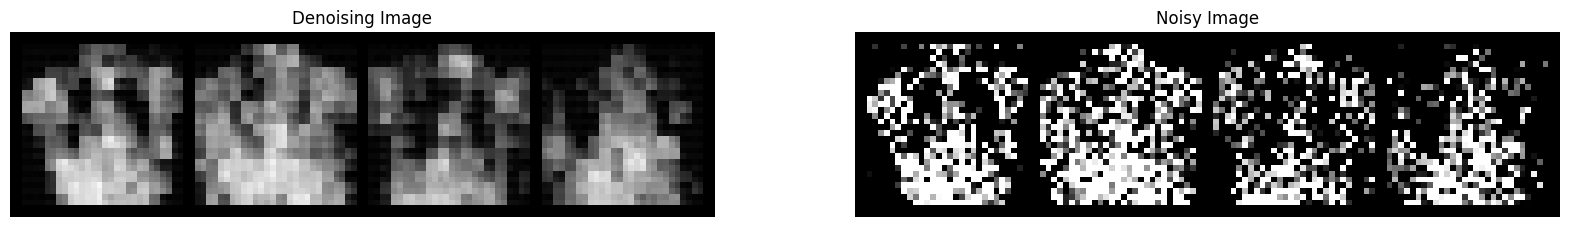

In [523]:
from matplotlib import image as mpimg


#
# Ваш код
#
def imshow(img):
    plt.imshow(img)
    plt.show()
train_dataset.montage(1)
plt.figure(figsize=(20,20))
img = mpimg.imread("denoised4.png")
img1 = mpimg.imread("noisy4.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Denoising Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img1)
plt.title('Noisy Image')
plt.axis('off')
plt.show()

## Контрольные вопросы

**В чем особенность архитектуры автокодировщиков?**

Ваш ответ: Количество нейронов на входе и на выходе совпадает из-за декодера и энкодера в составе автокодировщика

![img](https://neurohive.io/wp-content/uploads/2018/09/avtojenkoder-e1536675599885.png)

**Какие метрики можно использовать для оценки качества изображений?**

Ваш ответ: субъективное, PSNR (соотношение пиковый сигнал / шум), оценка резкости 
